### Import modules

In [2]:
#### Import modules required
import multiprocessing as mp
import numpy as np
import os
import itertools
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sys
import datetime
from matplotlib import cm

os.chdir("C:/Users/gy17m2a/OneDrive - University of Leeds/Project/RAMP-UA/experiments/calibration")

# PYABC (https://pyabc.readthedocs.io/en/latest/)
import pyabc
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior
# Quieten down the pyopencl info messages (just print errors)
import logging

logging.getLogger("pyopencl").setLevel(logging.ERROR)

# Import arbitrary distribution class for using posterior estimates as new priors
sys.path.append('..')
from ArbitraryDistribution import ArbitraryDistribution

# RAMP model
from microsim.initialisation_cache import InitialisationCache
# from microsim.opencl.ramp.run import run_headless
# from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
# from microsim.opencl.ramp.snapshot import Snapshot
# from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
# from microsim.opencl.ramp.simulator import Simulator
# from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Bespoke RAMP classes for running the model
import sys

sys.path.append('..')
from opencl_runner import OpenCLWrapper  # Some additional functions to simplify running the OpenCL model
from opencl_runner import OpenCLRunner

# Set this to False to recalculate all results (good on HPC or whatever).
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True


C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


#### Read spatial data

In [2]:
# from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
# devon_msoa_codes =  pd.read_csv("observation_data/devon_msoa_codes.csv")

#### Create observed cases data
Can maybe move processing into other file and save outputs and just read into avoid confusion

In [3]:
# Observed cases data
cases_msoa_weekly = pd.read_csv("observation_data/weekly_cases_msoas_shifted_mpld_smoothed_IS.csv")
# remove date column
cases_msoa_weekly = cases_msoa_weekly.iloc[:, 1:]
# Transpose
cases_msoa_weekly = cases_msoa_weekly.T

# Observations are cases per msoa.
# Store as an array for us in model (more efficient?)
# (first axis is the msoa number, second is the day)
observations_weekly_array = cases_msoa_weekly.to_numpy()

## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon_shifted_mpld_smoothed_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()

# Read in daily devon case data (interpoalted from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()


#### Setup Model
Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and
re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).


In [4]:
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

DATA_DIR = os.path.join("..", "..", "devon_data")
cache_dir = os.path.join(DATA_DIR, "caches")
cache = InitialisationCache(cache_dir=cache_dir)
if cache.is_empty():
    raise Exception(f"The cache in {cache_dir} has not been initialised. Probably need to run the code a",
                    "few cells up that initialises the population")

individuals_df, activity_locations = cache.read_from_cache()

print(f"Activity locations: {activity_locations}")


Activity locations: {'Home': <Home ActivityLocation>, 'Retail': <Retail ActivityLocation>, 'PrimarySchool': <PrimarySchool ActivityLocation>, 'SecondarySchool': <SecondarySchool ActivityLocation>, 'Work': <Work ActivityLocation>}


#### Define constants
These are not touched by ABC. Include parameters that should not be optimised.

In [5]:
const_params_dict = {
    "current_risk_beta": 0.025239665550846085,  # Global risk multplier (leave this as it is and allow the other parameters to vary)
    "home": 1.0, # Risk associated with being at home. Again leave this constant so the coefficients of other places will vary around it
}

#### Define random variables and the prior distributions
Random variables are the global parameters.

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


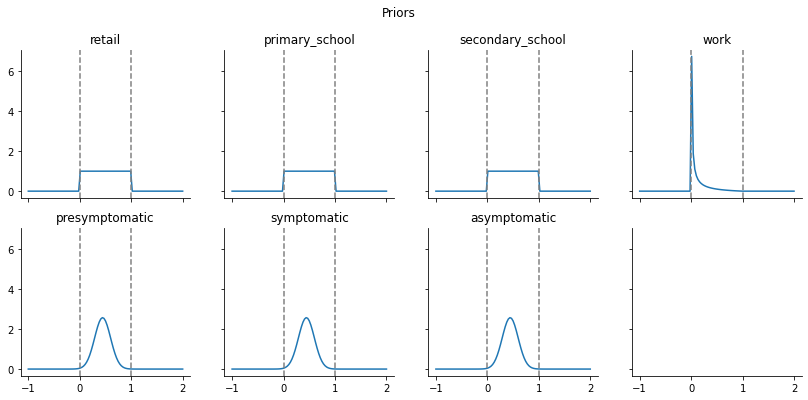

In [6]:
# School and retail multipliers are uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = (pyabc.RV("uniform", 0, 1) for _ in range(3))
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]  (see justification in abc)
# No idea about (pre)symptomatic, so use same distribution as asymptomatic
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = {
    "retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv
}

fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, (var_name, variable) in enumerate(all_rv.items()):
    # var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    # ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=0.0, ls='--', color="grey", label="x=0")
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")

# ax.legend()
# fig.tight_layout()
fig.suptitle("Priors")
fig.show()

## Create a distrubtion from these random variables
decorated_rvs = {name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items()}

# Define the original priors
original_priors = pyabc.Distribution(**decorated_rvs)

#### Setup loop for running model

In [ ]:
# Path to parameters
parameters_file = os.path.join("../../", "model_parameters/",
                               "default.yml")  # Need to tell it where the default parameters are
# Set the size of a data assimilation window in days:
da_window_size = 7
# Dictionary with parameters for running model
admin_params = {"quiet": True, "use_gpu": True, "store_detailed_counts": True, "start_day": 0,
                "run_length": da_window_size,
                "current_particle_pop_df": None,
                "parameters_file": parameters_file, "snapshot_file": SNAPSHOT_FILEPATH, "opencl_dir": OPENCL_DIR,
                "individuals_df": individuals_df, "observations_weekly_array": observations_weekly_array,
                 'num_seed_days' :7}

# Create dictionaries to store the dfs, weights or history from each window (don't need all of these, but testing for now)
dfs_dict = {}
weights_dict = {}
history_dict = {}

# Store starting time to use to calculate how long processing the whole window has taken
starting_windows_time = datetime.datetime.now()

# Define number of windows to run for
windows = 2

# Loop through each window
for window_number in range(1, windows + 1):
    print("Window number: ", window_number)

    # Edit the da_window size in the admin params
    # print("Running for 14 days")
    admin_params['run_length'] = admin_params['run_length'] * window_number
    print("Running for {} days".format(da_window_size * window_number))

    # Create template for model
    template = OpenCLWrapper(const_params_dict, **admin_params)
    # Not sure why this is needed. Wthout it we get an error when passing the template object to ABCSMC below
    template.__name__ = OpenCLWrapper.__name__

    # Define priors
    # If first window, then use user-specified (original) priors
    if window_number == 1:
        # with open('abc-2_105days_7seeddays.pkl', 'rb') as f:
        #     old_history = pickle.load(f)
        # priors = ArbitraryDistribution(old_history)
        priors = original_priors
    # If a subsequent window, then generate distribution from posterior from previous window
    else:
        priors = ArbitraryDistribution(abc_history)

    # Set up model
    abc = pyabc.ABCSMC(
        models=template,  # Model (could be a list)
        parameter_priors=priors,  # Priors (could be a list)
        # summary_statistics=OpenCLWrapper.summary_stats,  # Summary statistics function (output passed to 'distance')
        distance_function=OpenCLWrapper.dummy_distance,  # Distance function
        sampler=pyabc.sampler.SingleCoreSampler()
        # Single core because the model is parallelised anyway (and easier to debug)
        # sampler=pyabc.sampler.MulticoreEvalParallelSampler()  # The default sampler
        # transition=transition,  # Define how to transition from one population to the next
    )

    # Prepare to run the model
    db_path = ("sqlite:///" + "ramp_da.db")  # Path to database

    # abc.new() needs the database location and any observations that we will use (these are passed to the
    # distance_function provided to pyabc.ABCSMC above). Currently the observations are provided to the model
    # when it is initialised and these are then used at the end of the model run() function. So they don't
    # need to be provided here.
    run_id = abc.new(
        db=db_path,
        observed_sum_stat=None  # {'observation': observations_array, "individuals": individuals_df}
    )

    # Run model
    abc_history = abc.run(max_nr_populations=2)

    # Save some info on the posterior parameter distributions.
    for t in range(0, abc.history.max_t + 1):
        print(t)
        # for this t (population) extract the 100 particle parameter values, and their weights
        df_t1, w_t1 = abc.history.get_distribution(m=0, t=t)
        # Are these equivalent? yes!
        # df_t1_2, w_t1_2 = abc_history.get_distribution(m=0, t=abc_history.max_t)
        # df_t1.equals(df_t1_2)
        # (w_t1 == w_t1_2).all()

        # Save these for use in plotting the prior on the plot of parameter values in each population
        dfs_dict["w{},pop{}".format(window_number, t)] = df_t1
        weights_dict["w{}, pop{}".format(window_number, t)] = w_t1
        history_dict["w{}".format(window_number)] = abc_history


ABC.History INFO: Start <ABCSMC id=55, start_time=2022-02-21 10:43:18>
ABC INFO: Calibration sample t = -1.


Window number:  1
Running for 7 days
OpenclRunner ran model 5 in 0:00:01.647171
OpenclRunner ran model 6 in 0:00:01.588719
OpenclRunner ran model 7 in 0:00:01.517232
OpenclRunner ran model 8 in 0:00:01.499786
OpenclRunner ran model 9 in 0:00:01.559697
OpenclRunner ran model 10 in 0:00:01.504290
OpenclRunner ran model 11 in 0:00:01.514381
OpenclRunner ran model 12 in 0:00:01.479596
OpenclRunner ran model 13 in 0:00:01.487449
OpenclRunner ran model 14 in 0:00:01.455260
OpenclRunner ran model 15 in 0:00:01.419057
OpenclRunner ran model 16 in 0:00:01.446831
OpenclRunner ran model 17 in 0:00:01.452320
OpenclRunner ran model 18 in 0:00:01.433917
OpenclRunner ran model 19 in 0:00:01.562214
OpenclRunner ran model 20 in 0:00:01.364990
OpenclRunner ran model 21 in 0:00:01.496150
OpenclRunner ran model 22 in 0:00:01.518758
OpenclRunner ran model 23 in 0:00:01.406099
OpenclRunner ran model 24 in 0:00:01.412357
OpenclRunner ran model 25 in 0:00:01.402674
OpenclRunner ran model 26 in 0:00:01.463881


ABC INFO: t: 0, eps: 2.19014327e+03.


OpenclRunner ran model 105 in 0:00:01.529603
OpenclRunner ran model 106 in 0:00:01.473944
OpenclRunner ran model 107 in 0:00:01.533631
OpenclRunner ran model 108 in 0:00:01.565607
OpenclRunner ran model 109 in 0:00:01.376928
OpenclRunner ran model 110 in 0:00:01.525453
OpenclRunner ran model 111 in 0:00:01.503379
OpenclRunner ran model 112 in 0:00:01.508168
OpenclRunner ran model 113 in 0:00:01.503281
OpenclRunner ran model 114 in 0:00:01.476558
OpenclRunner ran model 115 in 0:00:01.304643
OpenclRunner ran model 116 in 0:00:01.548345
OpenclRunner ran model 117 in 0:00:01.525265
OpenclRunner ran model 118 in 0:00:01.529306
OpenclRunner ran model 119 in 0:00:01.538869
OpenclRunner ran model 120 in 0:00:01.544062
OpenclRunner ran model 121 in 0:00:01.511301
OpenclRunner ran model 122 in 0:00:01.537405
OpenclRunner ran model 123 in 0:00:01.513355
OpenclRunner ran model 124 in 0:00:01.587201
OpenclRunner ran model 125 in 0:00:01.532672
OpenclRunner ran model 126 in 0:00:01.583509
OpenclRunn

ABC INFO: Accepted: 100 / 100 = 1.0000e+00, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 2.19014327e+03.


OpenclRunner ran model 205 in 0:00:01.404702
OpenclRunner ran model 206 in 0:00:01.447665
OpenclRunner ran model 207 in 0:00:01.505362
OpenclRunner ran model 208 in 0:00:01.513222
OpenclRunner ran model 209 in 0:00:01.521631
OpenclRunner ran model 210 in 0:00:01.485496
OpenclRunner ran model 211 in 0:00:01.536075
OpenclRunner ran model 212 in 0:00:01.523574
OpenclRunner ran model 213 in 0:00:01.546033
OpenclRunner ran model 214 in 0:00:01.432308
OpenclRunner ran model 215 in 0:00:01.606517
OpenclRunner ran model 216 in 0:00:01.576207
OpenclRunner ran model 217 in 0:00:01.497942
OpenclRunner ran model 218 in 0:00:01.545866
OpenclRunner ran model 219 in 0:00:01.491395
OpenclRunner ran model 220 in 0:00:01.485235
OpenclRunner ran model 221 in 0:00:01.490461
OpenclRunner ran model 222 in 0:00:01.498472
OpenclRunner ran model 223 in 0:00:01.510876
OpenclRunner ran model 224 in 0:00:01.605539
OpenclRunner ran model 225 in 0:00:01.634317
OpenclRunner ran model 226 in 0:00:01.458768
OpenclRunn

ABC INFO: Accepted: 100 / 100 = 1.0000e+00, ESS: 2.0549e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=55, duration=0:11:32.006134, end_time=2022-02-21 10:54:50>
ABC.History INFO: Start <ABCSMC id=56, start_time=2022-02-21 10:54:50>


0
1
Window number:  2
Running for 14 days


ABC INFO: Calibration sample t = -1.


<Parameter 'asymptomatic': 0.9017906361026397, 'presymptomatic': 0.06408531501856679, 'primary_school': 1.0879701008610174, 'retail': 0.5790428876641087, 'secondary_school': 0.21543211350555314, 'symptomatic': 0.6198724652805404, 'work': 0.046885318691365016>
OpenclRunner ran model 305 in 0:00:01.855966
<Parameter 'asymptomatic': 0.43076392603309155, 'presymptomatic': 0.31374545361969236, 'primary_school': 0.06800363518218308, 'retail': 0.4627291696190662, 'secondary_school': 0.11442181203783822, 'symptomatic': 0.5924152774505347, 'work': 0.0332968653115247>
OpenclRunner ran model 306 in 0:00:02.114902
<Parameter 'asymptomatic': 0.34751623453836417, 'presymptomatic': 0.5241214786830865, 'primary_school': 0.30160740737060676, 'retail': 0.5849389314106761, 'secondary_school': 0.8040347455725574, 'symptomatic': 0.2750100200902457, 'work': 0.019647763725195666>
OpenclRunner ran model 307 in 0:00:02.351035
<Parameter 'asymptomatic': 0.20851078966117342, 'presymptomatic': 0.49182813913292595

OpenclRunner ran model 331 in 0:00:02.038722
Resampling
<Parameter 'asymptomatic': 0.42341438134541787, 'presymptomatic': 0.5856347133323712, 'primary_school': 0.6837106911280144, 'retail': 0.12554512405200896, 'secondary_school': 0.815076518170395, 'symptomatic': 0.35470472965117317, 'work': 0.1294100417237284>
OpenclRunner ran model 332 in 0:00:02.017231
Resampling
<Parameter 'asymptomatic': 0.5972747909510495, 'presymptomatic': 0.5868881468754148, 'primary_school': 0.796609197510487, 'retail': 0.5733719672463508, 'secondary_school': 0.4756786869517391, 'symptomatic': 0.29286390768958764, 'work': 0.05414191834703664>
OpenclRunner ran model 333 in 0:00:01.998416
Resampling
<Parameter 'asymptomatic': 0.4465242725262324, 'presymptomatic': 0.49950115582285926, 'primary_school': 0.732798330049312, 'retail': 0.6087098134195298, 'secondary_school': 0.6760590327120958, 'symptomatic': 0.47829279568663763, 'work': 0.028829852169971484>
OpenclRunner ran model 334 in 0:00:02.092435
<Parameter 'a

OpenclRunner ran model 358 in 0:00:01.983191
<Parameter 'asymptomatic': 0.4670342297366017, 'presymptomatic': 0.43951365463915426, 'primary_school': 0.8303315192922911, 'retail': 0.6418495172002037, 'secondary_school': 0.41190237393758866, 'symptomatic': 0.12381101188831965, 'work': 0.08860130549795721>
OpenclRunner ran model 359 in 0:00:02.092578
Resampling
Resampling
Resampling
Resampling
Resampling
<Parameter 'asymptomatic': 0.32348334098743764, 'presymptomatic': 0.615282354824965, 'primary_school': 0.1580069444032051, 'retail': 0.6044083080379493, 'secondary_school': 0.9477953384892647, 'symptomatic': 0.2516408779575217, 'work': 0.04251091060840994>
OpenclRunner ran model 360 in 0:00:02.041353
<Parameter 'asymptomatic': 0.19456376557572722, 'presymptomatic': 0.5833579964986351, 'primary_school': 0.07136361403034015, 'retail': 0.4257715872467786, 'secondary_school': 0.5535523053128901, 'symptomatic': 0.31807747060662445, 'work': 0.0500925675409284>
OpenclRunner ran model 361 in 0:00

Resampling
Resampling
<Parameter 'asymptomatic': 0.41993733309615355, 'presymptomatic': 0.6747603704034129, 'primary_school': 0.708619375929122, 'retail': 0.4465956992835383, 'secondary_school': 0.7681727378316562, 'symptomatic': 0.2711821694426734, 'work': 0.22396345200268078>
OpenclRunner ran model 385 in 0:00:02.065519
Resampling
<Parameter 'asymptomatic': 0.27203642315027604, 'presymptomatic': 0.5832635167755916, 'primary_school': 1.115612620352551, 'retail': 0.8779119392132638, 'secondary_school': 0.3807879703364882, 'symptomatic': 0.5383610570558358, 'work': 0.0842623834582095>
OpenclRunner ran model 386 in 0:00:02.104949
Resampling
Resampling
<Parameter 'asymptomatic': 0.3011443890691963, 'presymptomatic': 0.6829670968242256, 'primary_school': 0.23400298210488749, 'retail': 0.5533668268715801, 'secondary_school': 0.17801756262564616, 'symptomatic': 0.48297148942786644, 'work': 0.03821391035358543>
OpenclRunner ran model 387 in 0:00:01.978375
Resampling
<Parameter 'asymptomatic':

In [11]:
fname = "mollytest_2windows_7seeddays_olddist_rubbishresults.pkl"
with open( fname, "wb" ) as f:
        pickle.dump( abc_history, f)

#### Get results at end of each window

In [19]:
# Get model predictions, and particle fitnesses for each particle in the final 
# population 
abc_sum_stats = {}

for window, n_days in { "w1": 14, "w2":28}.items():
    
    # Create lists to store values for each particle
    fitness_l, daily_preds_l, params_l = [],[],[]
    
    # get the history for this window    
    history_wx  = history_dict[window]   
    
    # Get parameter values
    parameter_vals_df, w = history_wx.get_distribution(m=0, t=history.max_t)

    # Get the summary stats for the final population for this window ([1] means keep just the 
    # dataframe and not the array of weights)
    weighted_sum_stats_t0 = history_wx.get_weighted_sum_stats_for_model(t=history_wx.max_t)[1]
    # Loop through each particle and save their fitness and predictions into the lists
    for particle_no in range(0,100):
        # Get data for just this particle
        particle_x_dict = weighted_sum_stats_t0[particle_no]
        
        # Get daily predictions
        cumulative_model_diseased_by_area = particle_x_dict["cumulative_model_diseased_by_area"]
        cumulative_model_diseased_by_area = cumulative_model_diseased_by_area.iloc[:,0:n_days]
        cumulative_model_diseased_by_area_devon_sum = cumulative_model_diseased_by_area.sum(axis=0)
    
        # Add daily predictions for this particle to list
        daily_preds_l.append(cumulative_model_diseased_by_area_devon_sum.values)
        
        # Add fitness to list
        fitness_l.append(particle_x_dict['distance'])
        
        # Add parameter values to list
        params_l.append(parameter_vals_df.iloc[particle_no])
        
    # Add to dictionary for this window
    abc_sum_stats[window] = {'fitness_ls':fitness_l, 'daily_preds_ls' :daily_preds_l,
                             'params_ls':params_l}

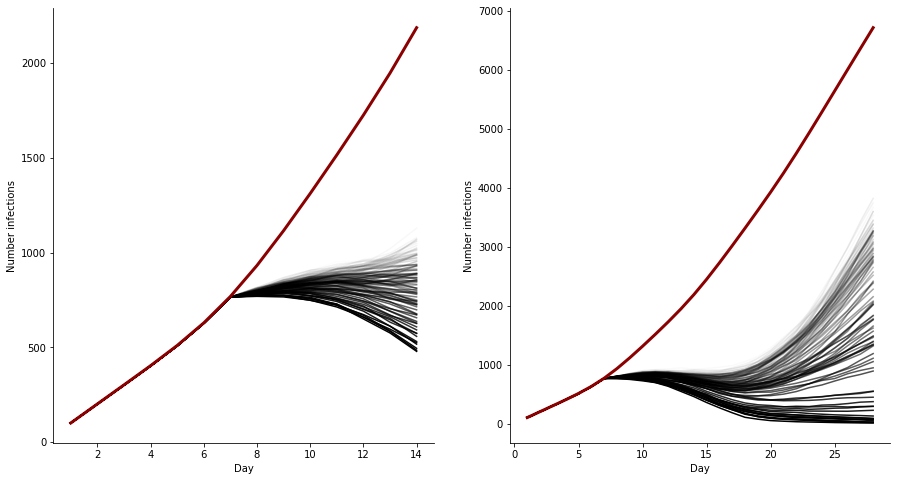

In [20]:
# For each window, plot the predictions rom each particle in the final population
fig, axes = plt.subplots(1, 2, figsize=(15,8))
axes_number = 0
for window, n_days in { "w1": 14, "w2":28}.items():
    # Get data for this window
    daily_preds_ls  = abc_sum_stats[window]['daily_preds_ls']   
    fitness_l = abc_sum_stats[window]['fitness_ls']   

    # Normalise fitness to 0-1 to calculate transparency
    _fitness = np.array(fitness_l)  # Easier to do maths on np.array
    fitness_norm = (_fitness - min(_fitness)) / (max(_fitness) - min(_fitness))
    
    # define number of days these results relate to
    x=range(1,n_days+1)    
    
    # For each particle, plot the predictions, coloured by fitness
    for i in range(0,len(daily_preds_l)):
        axes[axes_number].plot(x, daily_preds_ls[i],
                color="black", alpha=1 - fitness_norm[i])  # (1-x because high fitness is bad)
   
    # Add observations
    axes[axes_number].plot(x, initial_cases['CumulativeCases'][0:len(daily_preds_ls[0])], label="Observations",
                           linewidth = 3, color="darkred")

    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_ylabel("Number infections")
    
    axes_number =axes_number +1

# best_particle_idx = abc_sum_stats[window]['fitness_ls'].index(min(abc_sum_stats[window]['fitness_ls']))
# best_params =abc_sum_stats[window]['params_ls'][best_particle_idx]

#### Plot the parameter values being used in each window
Doesn't work, unless rerun prior bit at top, not sure why

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


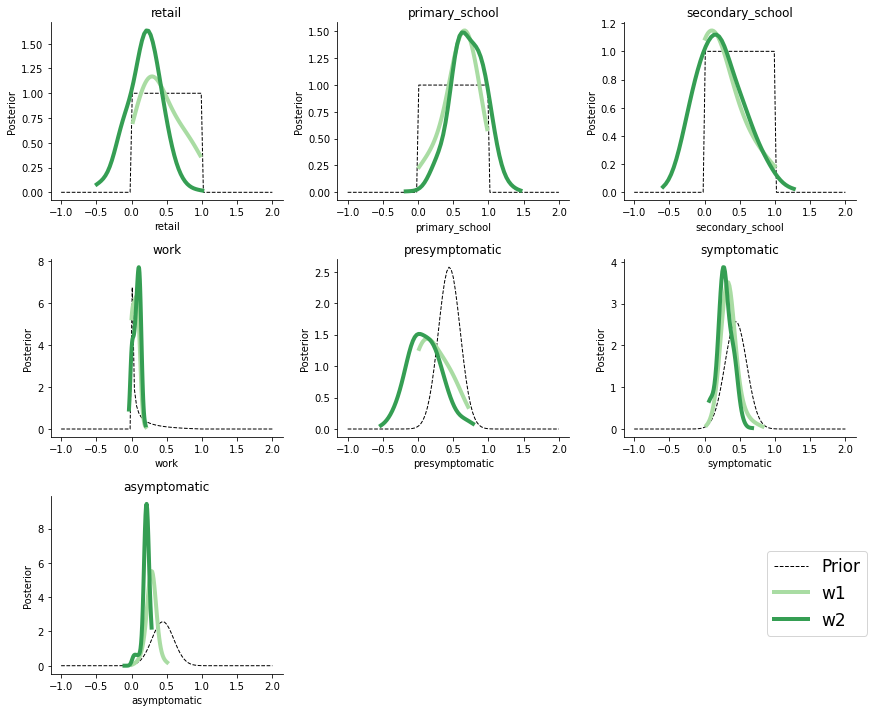

In [11]:
#### Final population for each window
evenly_spaced_interval = np.linspace(0.35, 1, 3)
colors = [cm.Greens(x) for x in evenly_spaced_interval]

fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        df, w = history.get_distribution(m=0, t=history.max_t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label=history_name, linewidth = 4,
                color= color)
        ax.legend(fontsize="small")
        ax.set_title(f"{param}")
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        color_i = color_i +1
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()
# fig.savefig("Plots/8windows_14days_each_finalpop.jpg")

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


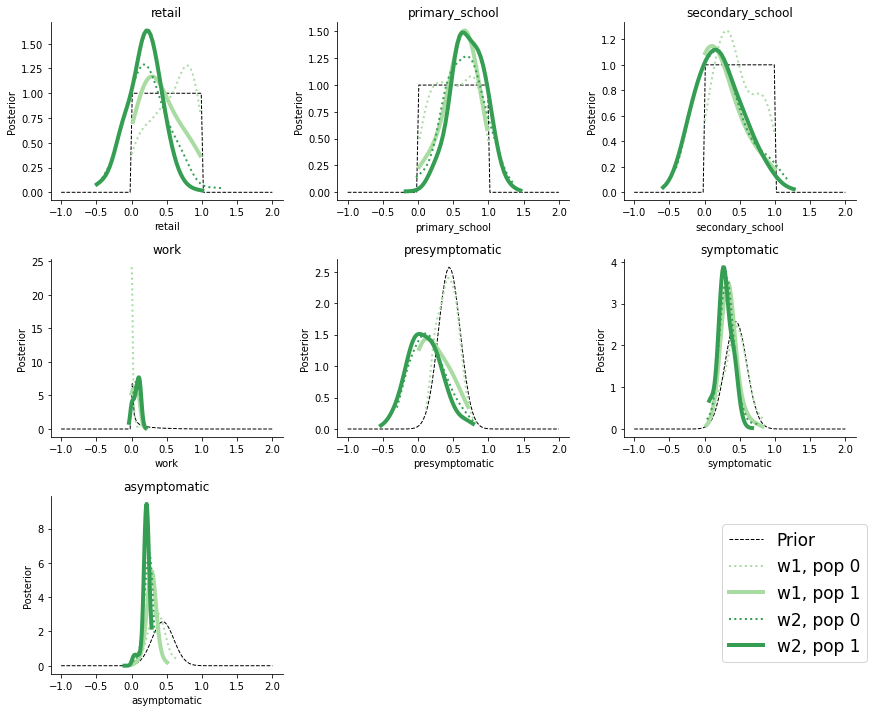

In [12]:
### Plot all populations for each window
evenly_spaced_interval = np.linspace(0.35, 1, 3)
colors = [cm.Greens(x) for x in evenly_spaced_interval]
linestyles = ['dotted','solid'] # check this is same length as n populations
linewidths = [2,4]
fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        for t in range(history.max_t + 1):
            df, w = history.get_distribution(m=0, t=t)
            pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label="{}, pop {}".format(history_name, t),
                color = color,
                linestyle = linestyles[t],linewidth = linewidths[t])
            ax.legend(fontsize="small")
            #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
            ax.set_title(f"{param}")
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
        color_i = color_i +1
        
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()

#### Run the model X (50?) times using paramater values drawn from the posterior
Plot the results to compare the performance of the model with the observations

In [9]:
# Initialise the class so that its ready to run the model.
## Define parameters
PARAMETERS_FILE = os.path.join("../../", "model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

ITERATIONS = 105  # Number of iterations to run for
assert (ITERATIONS /7).is_integer()
NUM_SEED_DAYS = 7  # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True
# assert ITERATIONS < len(OBSERVATIONS), \
# f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

OpenCLRunner.init(iterations=ITERATIONS,
                  repetitions=REPETITIONS,
                  observations=cases_devon_weekly,
                  use_gpu=USE_GPU,
                  use_healthier_pop=USE_HEALTHIER_POP,
                  store_detailed_counts=STORE_DETAILED_COUNTS,
                  parameters_file=PARAMETERS_FILE,
                  opencl_dir=OPENCL_DIR,
                  snapshot_filepath=SNAPSHOT_FILEPATH,
                  num_seed_days = NUM_SEED_DAYS)

# Set constants 
OpenCLRunner.set_constants(const_params_dict)

##### define the abc_history object (not necessary as this will be most recent abc_history anyway)
abc_history = history_dict['w2']

# Define the number of samples to take from the posterior distribution of parameters
N_samples = 30
df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

# Now run N models and store the results of each one
fitness_l, sim_l, obs_l, out_params_l,out_calibrated_params_l, summaries_l = [],[],[],[],[],[] 

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():
    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        # while (any(value < 0 for value in sample.values())):
        print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()
        # Added in this line as the sample was in the wrong format for the while loop
        sample = pd.Series(sample)

    # Create a dictionary with the parameters and their values for this sample
    #param_values = {param: sample[str(param)] for param in priors}
    param_values = sample.to_dict()
    print(param_values)

    # _summaries = 
    (_fitness, _sim, _obs, _out_params, _summaries) = \
        OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    # print(f"Fitness: {_fitness}. Sample: {sample}")

    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")


# print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")

{'asymptomatic': 0.16852100524010408, 'presymptomatic': 0.21610817083524253, 'primary_school': 0.7075356511853669, 'retail': 0.2275557178921172, 'secondary_school': 0.17391691995699465, 'symptomatic': 0.3817984260996012, 'work': 0.10922448806589337}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.62s/it]


Fitness: 27798.16910005407.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.22338634125324053, 'presymptomatic': 0.17524396112599216, 'primary_school': 0.46314555571861604, 'retail': 0.39216550564344177, 'secondary_school': 0.25763605903261805, 'symptomatic': 0.10163920411315658, 'work': 0.027708170096791013}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.59s/it]


Fitness: 21991.749295159407.
{'asymptomatic': 0.20344553031110343, 'presymptomatic': 0.10299850308534354, 'primary_school': 0.741476585447487, 'retail': 0.1259928369860288, 'secondary_school': 0.3354095066278733, 'symptomatic': 0.17497409248845208, 'work': 0.07438673126602444}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.45s/it]


Fitness: 24823.156172715706.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.1913814938172035, 'presymptomatic': 0.13372439759256582, 'primary_school': 0.31702170975082933, 'retail': 0.44072622324071864, 'secondary_school': 0.43396825626752644, 'symptomatic': 0.5514243098326346, 'work': 0.0660243359340842}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.80s/it]


Fitness: 23750.78789650196.
{'asymptomatic': 0.027252526330334204, 'presymptomatic': 0.2768616662715395, 'primary_school': 0.7764420349057212, 'retail': 0.08184671095218693, 'secondary_school': 0.7044972991770831, 'symptomatic': 0.39726646363905316, 'work': 0.010249409883062778}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.43s/it]


Fitness: 42468.03822172625.
Found negatives. Resampling
{'asymptomatic': 0.19081322935652772, 'presymptomatic': 0.6085833276557531, 'primary_school': 0.966791633688071, 'retail': 0.13381971489060818, 'secondary_school': 0.3381627591133473, 'symptomatic': 0.20083698066688885, 'work': 0.014496209736575637}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.82s/it]


Fitness: 20053.899971921524.
Found negatives. Resampling
{'asymptomatic': 0.17981645747488875, 'presymptomatic': 0.1738354688974241, 'primary_school': 0.5867050415946595, 'retail': 0.4041372008692846, 'secondary_school': 0.3356562129157268, 'symptomatic': 0.24744978334475964, 'work': 0.053786947918551466}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.07s/it]


Fitness: 27940.066611629896.
{'asymptomatic': 0.143553569274743, 'presymptomatic': 0.026856568037926576, 'primary_school': 0.771628820789853, 'retail': 0.20681652280730772, 'secondary_school': 0.4271282036214866, 'symptomatic': 0.33311324499415296, 'work': 0.09141290513670067}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.00s/it]


Fitness: 35052.095010025456.
Found negatives. Resampling
{'asymptomatic': 0.15917599392665438, 'presymptomatic': 0.37856420455590145, 'primary_school': 1.114097293267897, 'retail': 0.12068385513409391, 'secondary_school': 0.44137332961414477, 'symptomatic': 0.05848083067554536, 'work': 0.05099883917180899}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.74s/it]


Fitness: 28911.949093570547.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.22163793330336168, 'presymptomatic': 0.2739319432500921, 'primary_school': 0.44908873399540833, 'retail': 0.4856621981957221, 'secondary_school': 0.2865152667302831, 'symptomatic': 0.06682594636861507, 'work': 0.002826213099856559}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.65s/it]


Fitness: 19691.852785411425.
{'asymptomatic': 0.19231306438146195, 'presymptomatic': 0.1695891148117581, 'primary_school': 0.7978572866138273, 'retail': 0.1823498898032968, 'secondary_school': 0.2949068840563017, 'symptomatic': 0.26841548235256674, 'work': 0.08508011665861998}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.30s/it]


Fitness: 24211.757614154845.
{'asymptomatic': 0.22396594436836856, 'presymptomatic': 0.3534557639162294, 'primary_school': 0.5074049926205247, 'retail': 0.458414675489914, 'secondary_school': 0.5020731178606878, 'symptomatic': 0.31873147236007215, 'work': 0.004748935326299293}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.80s/it]


Fitness: 14052.621061432897.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.19883388306250566, 'presymptomatic': 0.03505899260443823, 'primary_school': 0.41651864593168386, 'retail': 0.42094972383317525, 'secondary_school': 0.11332426028115436, 'symptomatic': 0.3405007620969519, 'work': 0.054439947312564387}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.14s/it]


Fitness: 27173.256365157762.
Found negatives. Resampling
{'asymptomatic': 0.19256649503318746, 'presymptomatic': 0.07942760679134751, 'primary_school': 0.46980645744393407, 'retail': 0.3669703031789757, 'secondary_school': 0.1464807461173982, 'symptomatic': 0.403803846013902, 'work': 0.07997341822100876}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.32s/it]


Fitness: 24939.40668854141.
Found negatives. Resampling
{'asymptomatic': 0.18265310454685546, 'presymptomatic': 0.16422466439298847, 'primary_school': 0.696528250037246, 'retail': 0.5893576130145497, 'secondary_school': 0.2644118677234355, 'symptomatic': 0.4907920902164795, 'work': 0.0961007422834848}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.81s/it]


Fitness: 23259.673530848053.
{'asymptomatic': 0.10535282889209815, 'presymptomatic': 0.046331203329518886, 'primary_school': 0.8867971956218913, 'retail': 0.17430582415160017, 'secondary_school': 0.1724405334333109, 'symptomatic': 0.19120037680861668, 'work': 0.12621493514735116}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.09s/it]


Fitness: 39846.62187461539.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.18645946902028998, 'presymptomatic': 0.38225027048635407, 'primary_school': 0.6838375835447895, 'retail': 0.5272662617104633, 'secondary_school': 0.8701792256322729, 'symptomatic': 0.41754411067431607, 'work': 0.05162162432840102}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.37s/it]


Fitness: 13117.92985267472.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.06133038392768608, 'presymptomatic': 0.14400835924484023, 'primary_school': 0.8240238880574339, 'retail': 0.31870196153583225, 'secondary_school': 0.6869904624717715, 'symptomatic': 0.5945747124756535, 'work': 0.042034168340451476}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.91s/it]


Fitness: 41314.33967558633.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.18020289536745807, 'presymptomatic': 0.16469633690850016, 'primary_school': 0.8185768332619822, 'retail': 0.26189022930893585, 'secondary_school': 0.5034676838018715, 'symptomatic': 0.4241912266222136, 'work': 0.09151743315584832}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.46s/it]


Fitness: 25267.696699168522.
{'asymptomatic': 0.19152734250044975, 'presymptomatic': 0.1777582582184206, 'primary_school': 0.5429082647376918, 'retail': 0.4305316911552283, 'secondary_school': 0.26353130491417287, 'symptomatic': 0.45045619881576193, 'work': 0.10896400459408104}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.04s/it]


Fitness: 22350.474362635.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.21102672608197587, 'presymptomatic': 0.1705271072670767, 'primary_school': 0.591575774699224, 'retail': 0.19386707281023213, 'secondary_school': 0.6463595792398853, 'symptomatic': 0.433551904337588, 'work': 0.052568020587549585}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.14s/it]


Fitness: 18147.298821870456.
{'asymptomatic': 0.10829798474020247, 'presymptomatic': 0.18279313969414449, 'primary_school': 0.7521465285922424, 'retail': 0.14579470292868577, 'secondary_school': 0.7768678151843251, 'symptomatic': 0.50309856453325, 'work': 0.05553662611566018}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.22s/it]


Fitness: 37099.49999664582.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.12069918088037736, 'presymptomatic': 0.4285553880093686, 'primary_school': 0.6416195393260447, 'retail': 0.2561161554491145, 'secondary_school': 0.7724073610627978, 'symptomatic': 0.4698293159383425, 'work': 0.07002599245271887}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.67s/it]


Fitness: 32355.69569308948.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.18904627897063456, 'presymptomatic': 0.33442255749706734, 'primary_school': 0.5259593132597655, 'retail': 0.3095880907505959, 'secondary_school': 0.5329434202156267, 'symptomatic': 0.3614345935303901, 'work': 0.024776572845251903}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.86s/it]


Fitness: 23319.859207278154.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.1605283910658942, 'presymptomatic': 0.4208636863477049, 'primary_school': 0.24279938113478244, 'retail': 0.7865757862971636, 'secondary_school': 0.40658861912417565, 'symptomatic': 0.4176297811113653, 'work': 0.007812564096048195}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.53s/it]


Fitness: 26811.242526086407.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.1832768950724996, 'presymptomatic': 0.34443046810336186, 'primary_school': 0.6661558842198161, 'retail': 0.35208643332427747, 'secondary_school': 0.3995649915519936, 'symptomatic': 0.20539719101609255, 'work': 0.02135618660688745}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.82s/it]


Fitness: 24556.62800121867.
{'asymptomatic': 0.17994824314936592, 'presymptomatic': 0.5601889145306929, 'primary_school': 0.7190398241474114, 'retail': 0.13465515415046633, 'secondary_school': 0.4994658901628871, 'symptomatic': 0.22160814259620337, 'work': 0.0039033519567218877}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.95s/it]


Fitness: 21441.54861323683.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.19357600889680354, 'presymptomatic': 0.032514916508407515, 'primary_school': 0.3752432041257868, 'retail': 0.04017445290716644, 'secondary_school': 0.1679974413453698, 'symptomatic': 0.3728400010722781, 'work': 0.0736567270307932}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.21s/it]


Fitness: 27878.68497077553.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.21519400359300328, 'presymptomatic': 0.005349213596388874, 'primary_school': 0.32192939350523025, 'retail': 0.3961094424584547, 'secondary_school': 0.42063035529728987, 'symptomatic': 0.4788588764459229, 'work': 0.09417064284054111}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.47s/it]


Fitness: 19738.72806647111.
{'asymptomatic': 0.2640194001382207, 'presymptomatic': 0.15935557252549168, 'primary_school': 0.34884895603603344, 'retail': 0.5399432116736211, 'secondary_school': 0.25418824328476686, 'symptomatic': 0.4613032592506071, 'work': 0.004235320803074611}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.26s/it]

Fitness: 12874.841728110076.
Finished sampling. Ignored 47 negative samples.


#### Plot the individual results for each sample

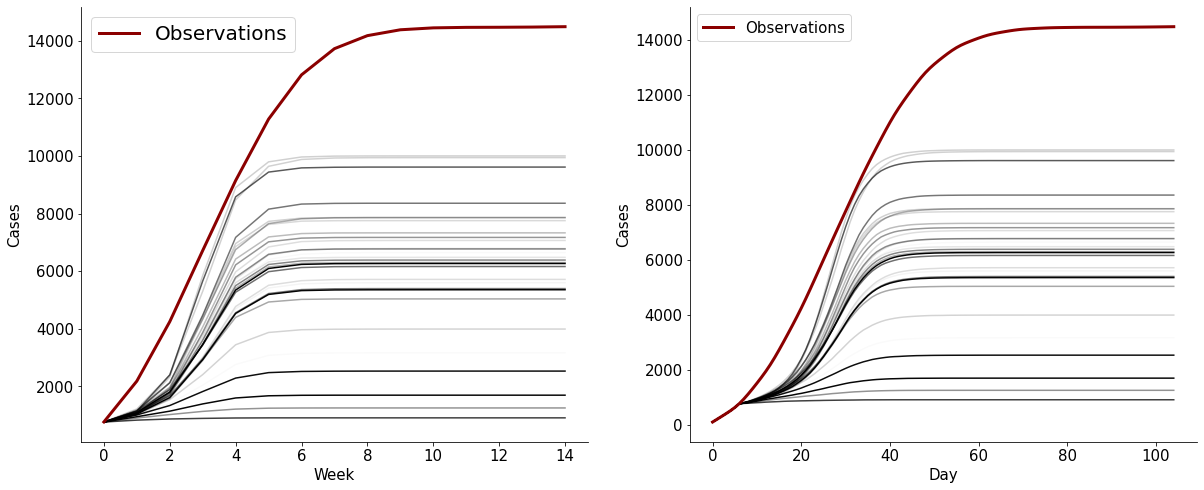

In [40]:
# Read in initial cases data (ued in seeding)
initial_cases = pd.read_csv("../../microsim/opencl/data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
initial_cases['CumulativeCases'] = initial_cases['num_cases'].cumsum()
initial_cases_weekly = pd.DataFrame({'OriginalCases':
                                    initial_cases['num_cases'].groupby(initial_cases['num_cases'].index // 7).sum()})
initial_cases_weekly['CumulativeCases'] = initial_cases_weekly.cumsum()

# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness - min(_fitness)) / (max(_fitness) - min(_fitness))

############## PLOT WEEKLY DATA
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax1.plot(x, sim_l[i],
            color="black", alpha=1 - fitness_norm[i]) # (1-x because high fitness is bad)
# Plot observations
ax1.plot(x, initial_cases_weekly['CumulativeCases'][0:int((105/7))], label="Observations", linewidth=3, color="darkred")
# Plot result from manually calibrated model
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Week", size=15)
ax1.set_ylabel("Cases",size=15)

############## PLOT DAILY DATA
x = range(len(OpenCLRunner.get_cumulative_new_infections(summaries_l[1])))
for i in range(len(summaries_l)):
    ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            # label=f"Particle {df.index[sample_idx[i]]}",
            color="black", alpha=1 - fitness_norm[i]  # (1-x because high fitness is bad)
            )
# Plot observations
ax2.plot(x, initial_cases['CumulativeCases'][0:105], label="Observations", linewidth = 3, color="darkred")
# Plot result from manually calibrated model
# ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# Format
ax2.legend(fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel("Day", size=15)
ax2.set_ylabel("Cases",size=15)

del _fitness, fitness_norm


In [21]:
####### Find the best parameters
best_model_idx = np.argmin(fitness_l)
best_params = out_calibrated_params_l[best_model_idx]
# Sanity check, the calibrated param should be the same as the one in the params object
assert np.isclose(out_calibrated_params_l[best_model_idx]['asymptomatic'],
                  out_params_l[best_model_idx].individual_hazard_multipliers[1])
print(best_params)

{'asymptomatic': 0.19256649503318746, 'presymptomatic': 0.07942760679134751, 'primary_school': 0.46980645744393407, 'retail': 0.3669703031789757, 'secondary_school': 0.1464807461173982, 'symptomatic': 0.403803846013902, 'work': 0.07997341822100876}


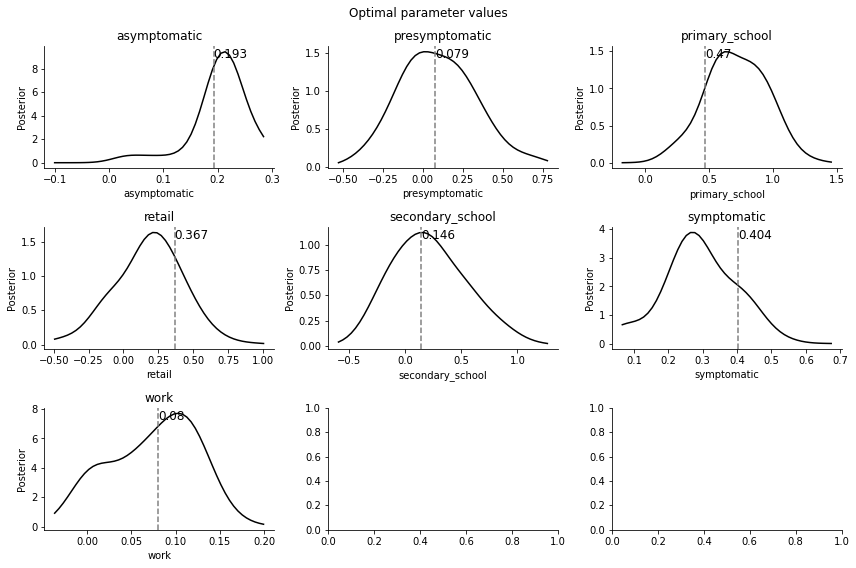

In [29]:
######## See how those parameters relate to the marginal posteriors
# fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,8))
fig, axes = plt.subplots(3,3, figsize=(12,8))
abc_history = history_dict['w2']
for i, param in enumerate(best_params.keys()):
    ax = axes.flat[i]
    df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
            label=f"{param} PDF t={t}",
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        )
    #ax.legend()
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

In [39]:
# best params1
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness1, sim1, obs1, out_params1, summaries1) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [02:33<00:00, 30.79s/it]


Fitness: 27230.62943236704


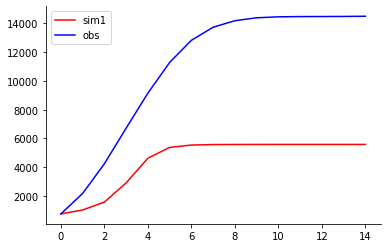

In [38]:
# Check the model returns the observations correctly (should be same as initial, default model)
# np.array_equal(obs0, obs1)
fig, ax = plt.subplots(1,1)
x = range(len(sim1))
# ax.plot(x, sim0, label="sim0", color="orange")
ax.plot(x, sim1, label="sim1", color="red")
# ax.plot(x, sim1_bp2, label="sim1_bp2", color="purple")
# Add fitness text
# for a, b in [(summaries0,fitness0), (summaries1, fitness1)]:
#     ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, initial_cases_weekly['CumulativeCases'][0:15], label="obs", color="blue")
ax.legend()
print(f"Fitness: {fitness1}")

### Save/pickle

In [41]:
fname = "2windows_7seeds_OldDistance_abc.pkl"
with open( fname, "wb" ) as f:
        pickle.dump( history, f)